In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.compat.v1 as tf
import random
import os
import time
import warnings

from scipy.io import loadmat
from scipy.stats import skew
from scipy.stats import gaussian_kde
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from datetime import timedelta
from tensorflow.python.client import device_lib
from tensorflow.compat.v1.keras.preprocessing import image
from tensorflow.compat.v1.keras.optimizers import Adam
from tensorflow.compat.v1.keras.preprocessing.image import ImageDataGenerator
from tensorflow.compat.v1.keras.callbacks import EarlyStopping

In [2]:
tf.__version__

'1.15.5'

In [3]:
def test_gpu():
    tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True))
    # Create two tensors for gpu test.
    print(tf.add([1.0, 2.0], [3.0, 4.0])) 
 
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    
    # Return a list of devices we can use in the notebook.
    return [x.name for x in local_device_protos]
    
test_gpu()
get_available_devices()

Executing op Add in device /job:localhost/replica:0/task:0/device:DML:0
tf.Tensor([4. 6.], shape=(2,), dtype=float32)


['/device:CPU:0', '/device:DML:0']

In [4]:
def get_data(dir_):
    # Load .mat data from current dir.
    svhn = loadmat(dir_)
    
    return svhn['X'], svhn['y']

def shape_data(X_train, y_train, X_test, y_test):
    # Exemple: X_train shape is (height, width, rgb, data_lenght) = (32, 32, 3, 73257).
    # After calling shape_data function X_train will be shape (data_lenght, height, width, rgb).
    X_train, y_train = X_train.transpose((3, 0, 1, 2)), y_train[:, 0]
    X_test, y_test = X_test.transpose((3, 0, 1, 2)), y_test[:, 0]
    
    return X_train, y_train, X_test, y_test

def loading_data():
    X_train, y_train = get_data('train_32x32.mat')
    X_test, y_test = get_data('test_32x32.mat')
    X_train, y_train,  X_test, y_test = shape_data(X_train, y_train, X_test, y_test)
    
    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = loading_data()

In [6]:
def random_values():
    # Generate random values from 1 to 5000 to plot data.
    return random.randint(1, 5000)

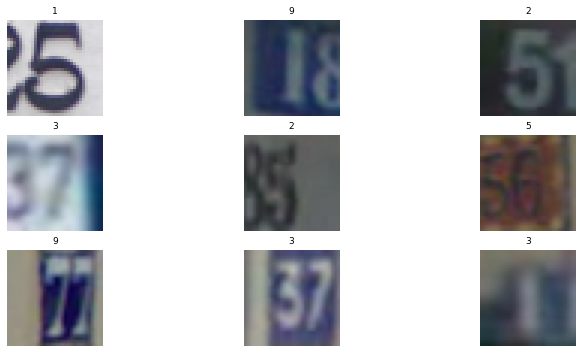

In [7]:
def data_view(data, label_values, rows, columns):
    fig, axs = plt.subplots(rows, columns, sharex=True, figsize=(rows * 4, columns * 2))
    
    for iter_, img in enumerate(axs.flat):
        img.imshow(data[random_values()])
        img.set_title(label_values[iter_], fontsize=9)
        img.axis('off')
        
data_view(X_train, y_train, 3, 3)

In [8]:
def skewness_check(label_values):
    # CHecking the data distribuition.
    print(skew(label_values))
    print(skew(label_values, bias=False))

In [9]:
print('Before data underweight\n')
skewness_check(y_train)

Before data underweight

0.4362057349038243
0.4362146668246221


In [10]:
print('After data underweight\n')
skewness_check(y_train)

After data underweight

0.4362057349038243
0.4362146668246221


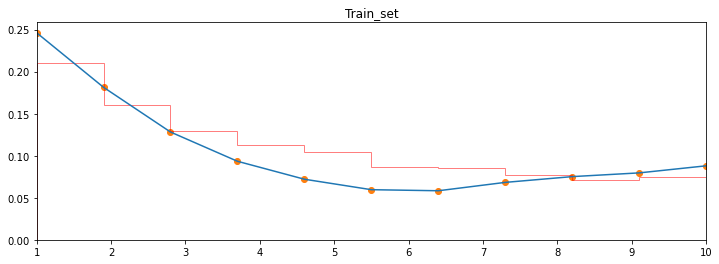

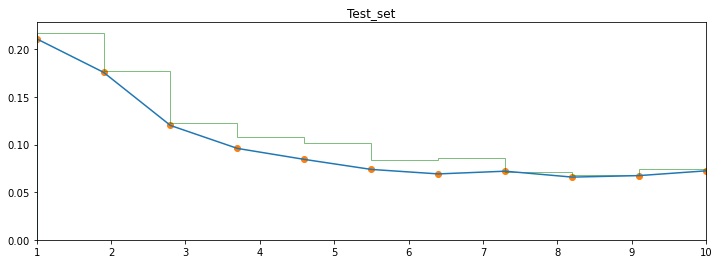

In [11]:
def distribution_view(rows, columns, label_values, bins, name, color, alpha):
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(rows * 3, columns))
    density = gaussian_kde(label_values)
    n, x, _ = ax.hist(label_values, bins=bins, color=color, alpha=alpha, density=True, histtype=u'step')
    plt.plot(x, density(x))
    plt.scatter(x, density(x))
    
    ax.set_title('Train_set', fontsize=12) if name == 'y_train' else ax.set_title('Test_set', fontsize=12)
    ax.set_xlim(1, 10)
    
    plt.show()
    
distribution_view(4, 4, y_train, 10, 'y_train', 'red', 0.5)
distribution_view(4, 4, y_test, 10, 'y_test', 'green', 0.5)

In [12]:
def data_underweight(label_values):
    # Deleting the values == 10 from output_values -> make it skew positive.
    label_values[label_values == 10] = 0

    return label_values

y_train = data_underweight(y_train)
y_test = data_underweight(y_test)

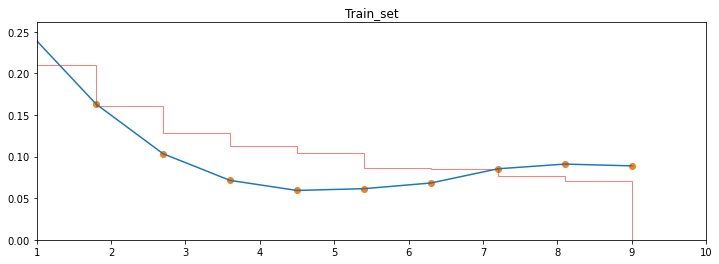

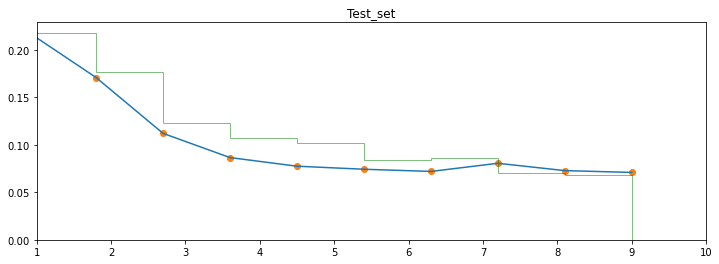

In [13]:
distribution_view(4, 4, y_train, 10, 'y_train', 'red', 0.5)
distribution_view(4, 4, y_test, 10, 'y_test', 'green', 0.5)

In [14]:
def train_test_split_(data, label_values):
    X_train, X_validation, y_train, y_validation = train_test_split(
        data, label_values, test_size=0.25, shuffle=True, random_state=120  
    )
    
    return X_train, X_validation, y_train, y_validation

X_train, X_validation, y_train, y_validation = train_test_split_(X_train, y_train)

In [15]:
def RGB2GRAY(imgs, rgb_weights, axs):
    # Make an image gray color.
    return np.expand_dims(np.dot(imgs, rgb_weights), axis=axs)

rgb_weights = [0.2989, 0.5870, 0.1140] # Do not touch this, gray parameters.
X_train_grayscale = RGB2GRAY(X_train, rgb_weights, 3).astype(np.float32)
X_test_grayscale = RGB2GRAY(X_test, rgb_weights, 3).astype(np.float32)
X_validation_grayscale = RGB2GRAY(X_validation, rgb_weights, 3).astype(np.float32)

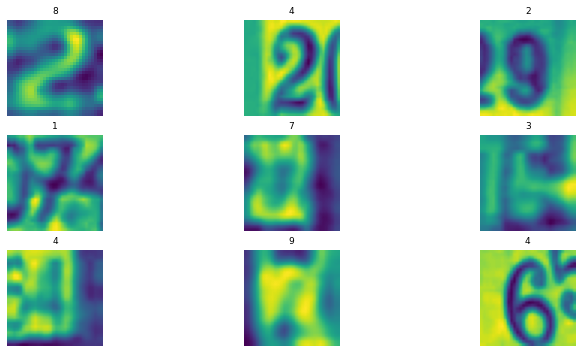

In [16]:
data_view(X_train_grayscale, y_train, 3, 3)

In [17]:
def OneHotEncoder_(label_values):
    # Inicializing the encoder.
    return OneHotEncoder().fit(label_values.reshape(-1, 1))

def apply_encoding(label_values):
    enc = OneHotEncoder_(label_values)
    label_values = enc.transform(label_values.reshape(-1, 1)).toarray()
    
    return label_values

y_train = apply_encoding(y_train)
y_test = apply_encoding(y_test)
y_validation = apply_encoding(y_validation)

In [18]:
def session_run():
    init_op = tf.global_variables_initializer()
    session = tf.Session()
    session.run(init_op)
    
    return session

In [19]:
def placeholders(height, width, color_channel, data_name, label_name, discart_name):
    composition = height * width
    
    tf.logging.set_verbosity(tf.logging.INFO)
    tf.disable_eager_execution()
    
    X = tf.placeholder(tf.float32, shape=[None, height, width, color_channel], name=data_name)
    y = tf.placeholder(tf.float32, shape=[None, 10], name=label_name)
    # y_cls is a auxiliary for the classification, y auxiliary.
    y_cls = tf.argmax(y, 1)
    
    discart_rate = tf.placeholder(tf.float32, name=discart_name)
    
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    
    return composition, X, y, y_cls, discart_rate

composition, X, y, y_cls, discart_rate = placeholders(32, 32, 1, 'Data', 'Labels', 'Discart_rate')

In [20]:
def checkpoint_path():
    
    return os.path.join(checkpoint_dir(), 'model_checkpoint')

def checkpoint_dir():
    checkpoint_dir = 'checkpoints/'
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    return checkpoint_dir

def checkpoint_saver():
    checkpoint = tf.train.Saver()
    checkpoint_dir_ = checkpoint_dir()       
    checkpoint_path_ = checkpoint_path()
        
    return checkpoint

In [74]:
def build_model(X, y, height, width, color_channel, filter_value, k_height, k_width, padding_, activation_, units_dense, units_logits, p_height, p_width, strides_, drop_, patience_):   
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filter_value[0], (k_height, k_width), padding=padding_, activation=activation_, input_shape=(height, width, color_channel)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((p_height, p_width), strides=strides_),
        tf.keras.layers.Dropout(drop_),
        tf.keras.layers.Conv2D(filter_value[1], (k_height, k_width), padding=padding_, activation=activation_),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((p_height, p_width), strides=strides_),
        tf.keras.layers.Dropout(drop_),
        tf.keras.layers.Conv2D(filter_value[2], (k_height, k_width), padding=padding_, activation=activation_),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(drop_),
        tf.keras.layers.MaxPooling2D((p_height, p_width), strides=strides_),
        tf.keras.layers.Conv2D(filter_value[3], (k_height, k_width), padding=padding_, activation=activation_),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((p_height, p_width), strides=strides_),
        tf.keras.layers.Dropout(drop_),
        tf.keras.layers.Conv2D(filter_value[4], (k_height, k_width), padding=padding_, activation=activation_),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((p_height, p_width), strides=strides_),
        tf.keras.layers.Dropout(drop_),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units_dense, activation=activation_),
        tf.keras.layers.Dropout(drop_),
        tf.keras.layers.Dense(units=units_logits)
    ])

    checkpoint_path_ = checkpoint_path()
    
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path_,
        save_weights_only=False,
        monitor='loss',
        mode='min',
        save_best_only=True
    )

    callbacks = [
        EarlyStopping(patience=patience_),
        model_checkpoint_callback
    ]
    
    return model, callbacks

filter_value = [32, 64, 128, 256, 512]
model, callbacks = build_model(X, y, 32, 32, 1, filter_value, 5, 5, 'same', tf.nn.relu, 256, 10, 2, 2, 2, 0.2, 10)

In [75]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [76]:
history = model.fit(X_train_grayscale, y_train, epochs=500, validation_data=(X_validation_grayscale, y_validation), callbacks=callbacks)

Train on 54942 samples, validate on 18315 samples
Epoch 1/500
54942/54942 [==============================] - 59s 1ms/sample - loss: 1.0297 - acc: 0.6604 - val_loss: 0.5880 - val_acc: 0.8196
Epoch 2/500
54942/54942 [==============================] - 57s 1ms/sample - loss: 0.4804 - acc: 0.8589 - val_loss: 0.9662 - val_acc: 0.7975
Epoch 3/500
54942/54942 [==============================] - 57s 1ms/sample - loss: 0.3913 - acc: 0.8857 - val_loss: 0.3557 - val_acc: 0.8982
Epoch 4/500
54942/54942 [==============================] - 57s 1ms/sample - loss: 0.3456 - acc: 0.9006 - val_loss: 0.4009 - val_acc: 0.8829
Epoch 5/500
54942/54942 [==============================] - 57s 1ms/sample - loss: 0.3093 - acc: 0.9095 - val_loss: 0.4456 - val_acc: 0.8834
Epoch 6/500
54942/54942 [==============================] - 57s 1ms/sample - loss: 0.2814 - acc: 0.9179 - val_loss: 0.2949 - val_acc: 0.9200
Epoch 7/500
54942/54942 [==============================] - 57s 1ms/sample - loss: 0.2528 - acc: 0.9271 - val_l

In [77]:
checkpoint_save = checkpoint_saver()
session = session_run()
checkpoint_save.save(sess=session, save_path=checkpoint_path())

Device mapping:
/job:localhost/replica:0/task:0/device:DML:0 -> {"name": "Radeon RX 580 Series", "vendor_id": 4098, "device_id": 26591, "driver_version": "30.0.13025.5005"}



'checkpoints/model_checkpoint'

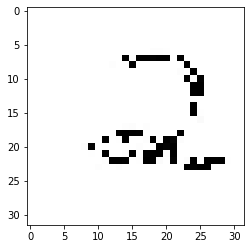

Labels:  [[-10.30678     -7.3160324   -0.07593294  -0.8895739   -8.309523
   -7.686437    -9.063738    -7.166794   -10.93259    -11.984227  ]] 

Pred value: [2]


In [91]:
img = image.load_img('my_test.jpg', target_size=(32, 32))

plt.imshow(img)
plt.show()

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)
img = RGB2GRAY(img, rgb_weights, 3)

img_pred = model.predict(img)
print('Labels: ', img_pred, '\n')
img_pred_value = np.where(img_pred == np.amax(img_pred))
print('Pred value:', img_pred_value[1])

In [82]:
metrics_df = pd.DataFrame(history.history)
metrics_df

,loss,acc,val_loss,val_acc
0,1.029673,0.660442,0.587956,0.819601
1,0.480437,0.858869,0.966219,0.797488
2,0.391273,0.885698,0.355700,0.898171
3,0.345571,0.900622,0.400936,0.882937
4,0.309333,0.909523,0.445568,0.883374
5,0.281370,0.917932,0.294933,0.920011
6,0.252838,0.927050,0.312776,0.918919
7,0.236462,0.931619,0.282604,0.924051
8,0.217445,0.935951,0.285285,0.922359
9,0.203775,0.940373,0.290089,0.920175


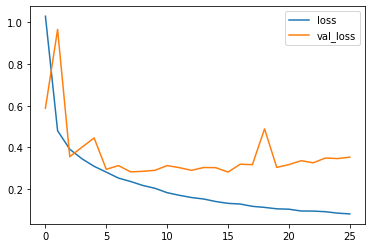

In [83]:
metrics_df[['loss', 'val_loss']].plot()
plt.show()

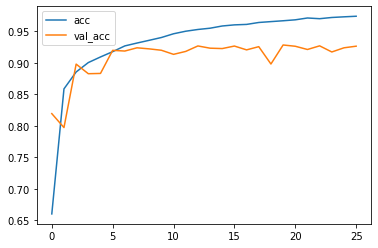

In [84]:
metrics_df[['acc', 'val_acc']].plot()
plt.show()

In [85]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 32, 32, 32)        832       
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 8, 8, 64)         